In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import * 

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

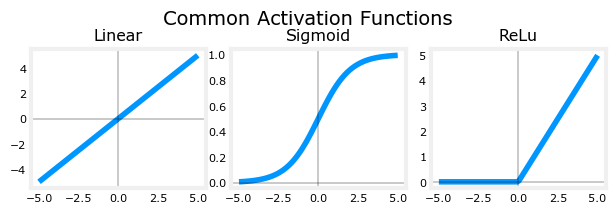

In [2]:
plt_act_trio()

In [3]:
# UNQ_C1
# GRADED CELL: my_softmax

def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """    
    ### START CODE HERE ### 
    a=np.exp(z)/(np.exp(z).sum())
    ### END CODE HERE ### 
    return a

In [4]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

# BEGIN UNIT TEST  
test_my_softmax(my_softmax)
# END UNIT TEST  

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


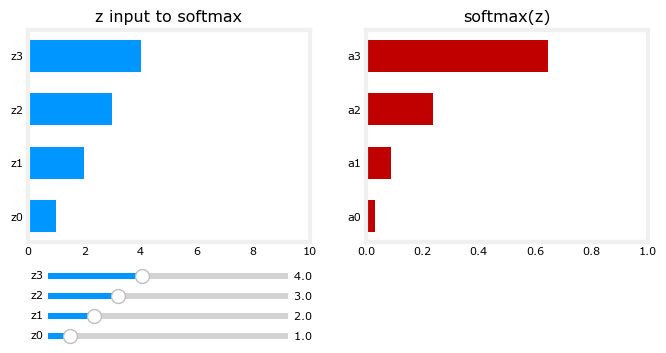

In [5]:
plt.close("all")
plt_softmax(my_softmax)

In [6]:
# load dataset
X, y = load_data()

In [7]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [8]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ('The shape of X is: ' + str(X_train.shape))
print ('The shape of y is: ' + str(y_train.shape))

The shape of X is: (4000, 400)
The shape of y is: (4000, 1)


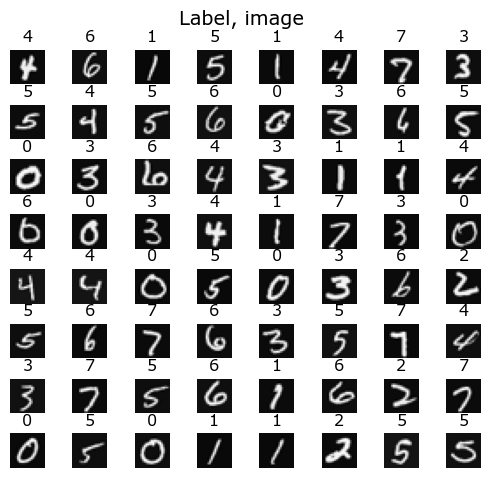

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X_train.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

In [11]:
class PrintWPValueGradientAndLoss(tf.keras.callbacks.Callback):
    def __init__(self, x, y, **kwargs):
        super(PrintWPValueGradientAndLoss, self).__init__(**kwargs)
        self.x = x
        self.y = y

    def on_batch_end(self, batch, logs=None):
        p_value = self.model.layers[0].p.numpy()
        
        # Choose the corresponding batch of data
        x_batch = self.x[batch * 32: (batch + 1) * 32]
        y_batch = self.y[batch * 32: (batch + 1) * 32]
        
        # Compute gradients of the loss with respect to the model's trainable variables
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)  # Ensure trainable variables are being watched
            predictions = self.model(x_batch, training=True)
            loss = tf.keras.losses.mean_squared_error(y_batch, predictions)
        grads = tape.gradient(loss, self.model.trainable_variables)
        
        # Assuming the order of trainable variables is p, w, b
        p_gradient = grads[0]  
        
        batch_loss = logs["loss"] 
        print(f"\nBatch {batch + 1} | Loss: {batch_loss:.15f} | "
              f"Mean_p: {np.mean(p_value):.15f} | Mean_gp: {np.mean(p_gradient):.15f}")



In [12]:
from wxpb_Layer_nn import PowerLayer
from wxpb2_Layer_nn import PowerLayer2
from wxb_Layer_nn import DenseLikeLayer
from wx2b_Layer_nn import DenseSquareLayer

In [23]:
tf.random.set_seed(1234)
from keras import regularizers
model = Sequential(
    [               
        tf.keras.Input(shape=(400,)),
        PowerLayer(units=25,activation='relu',name='L1',kernel_regularizer=regularizers.l2(0.0001)),
        DenseLikeLayer(units=15,activation='relu',name='L2'),
        DenseLikeLayer(units=10,activation='linear',name='L3'),
    ], name = "my_model" 
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (PowerLayer)             (None, 25)                20025     
                                                                 
 L2 (DenseLikeLayer)         (None, 15)                390       
                                                                 
 L3 (DenseLikeLayer)         (None, 10)                160       
                                                                 
Total params: 20,575
Trainable params: 20,575
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras import regularizers
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        DenseLikeLayer(units=25,activation='relu',name='L1',kernel_regularizer=regularizers.l2(0.0001)),
        DenseLikeLayer(units=15,activation='relu',name='L4',kernel_regularizer=regularizers.l2(0.0001)),
        DenseLikeLayer(units=10,activation='linear',name='L3'),
    ], name = "my_model" 
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (DenseLikeLayer)         (None, 25)                10025     
                                                                 
 L4 (DenseLikeLayer)         (None, 15)                390       
                                                                 
 L3 (DenseLikeLayer)         (None, 10)                160       
                                                                 
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
model.compile(
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

history = model.fit(
    X_train,y_train,
    epochs=100,
    # callbacks=[PrintWPValueGradientAndLoss( X,y)]
)

Epoch 1/100
125/125 [==============================] - 1s 5ms/step - loss: 1.1681
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 0.4744
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 0.3710
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 0.3544
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 0.3841
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 0.3483
Epoch 7/100
125/125 [==============================] - 1s 5ms/step - loss: 0.4155
Epoch 8/100
125/125 [==============================] - 1s 5ms/step - loss: 0.5617
Epoch 9/100
125/125 [==============================] - 1s 5ms/step - loss: 0.4816
Epoch 10/100
125/125 [==============================] - 1s 5ms/step - loss: 0.2464
Epoch 11/100
125/125 [==============================] - 1s 5ms/step - loss: 0.2925
Epoch 12/100
125/125 [==============================] - 1s 5ms/step - loss: 0.2801
Epoch 13/100


KeyboardInterrupt: 

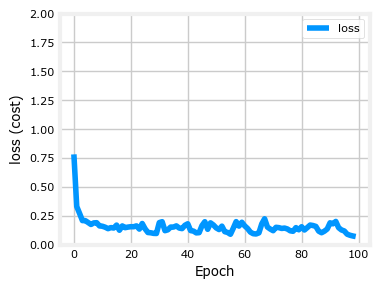

In [16]:
plot_loss_tf(history)

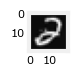

1/1 [==============================] - 0s 74ms/step
 predicting a Two: 
[[ -6.63  -8.64  17.56  -3.76  -8.23  -2.84   2.67 -19.66  -5.11 -11.  ]]
 Largest Prediction index: 2


In [17]:
image_of_two = X_test[3]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

The largest output is prediction[2], indicating the predicted digit is a '2'. If the problem only requires a selection, that is sufficient. Use NumPy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to select it. If the problem requires a probability, a softmax is required:

In [18]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[3.13e-11 4.21e-12 1.00e+00 5.54e-10 6.35e-12 1.39e-09 3.42e-07 6.89e-17
  1.43e-10 3.96e-13]]
Total of predictions: 1.000


To return an integer representing the predicted target, you want the index of the largest probability. This is accomplished with the Numpy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [19]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

In [20]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# # You do not need to modify anything in this cell

# m, n = X_test.shape

# fig, axes = plt.subplots(8,8, figsize=(5,5))
# fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
# widgvis(fig)
# for i,ax in enumerate(axes.flat):
#     # Select random indices
#     random_index = np.random.randint(m)
    
#     # Select rows corresponding to the random indices and
#     # reshape the image
#     X_random_reshaped = X_test[random_index].reshape((20,20)).T
    
#     # Display the image
#     ax.imshow(X_random_reshaped, cmap='gray')
    
#     # Predict using the Neural Network
#     prediction = model.predict(X_test[random_index].reshape(1,400))
#     prediction_p = tf.nn.softmax(prediction)
#     yhat = np.argmax(prediction_p)
    
#     # Display the label above the image
#     ax.set_title(f"{y_test[random_index,0]},{yhat}",fontsize=10)
#     ax.set_axis_off()
# fig.suptitle("Label, yhat", fontsize=14)
# plt.show()

Let's look at some of the errors. 
>Note: increasing the number of training epochs can eliminate the errors on this data set.

32/32 [==============================] - 0s 708us/step


1/1 [==============================] - 0s 15ms/step
58 errors out of 1000 images


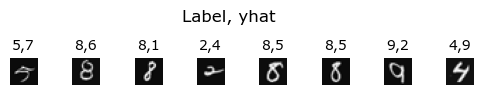

In [21]:
print( f"{display_errors(model,X_test,y_test)} errors out of {len(X_test)} images")

125/125 [==============================] - 0s 636us/step


TypeError: 'Axes' object is not subscriptable

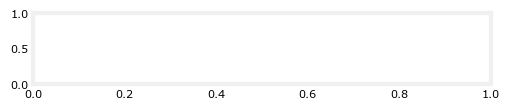

In [22]:
print( f"{display_errors(model,X_train,y_train)} errors out of {len(X_train)} images")

### Congratulations!
You have successfully built and utilized a neural network to do multiclass classification.

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>